# STAT 542 / CS 598: Example Homework

Spring 2019, by Edgar Pino (edgarsp2)

Due: Monday, Sep 9 by 11:59 PM Pacific Time.

## Question 1 [50 Points] KNN

1A. [15 Points] Write a function myknn(xtest, xtrain, ytrain, k) that fits a KNN model that predict a target point or multiple target points xtest. Here xtrain is the training dataset covariate value, ytrain is the training data outcome, and k is the number of nearest neighbors. Use the ℓ2 norm to evaluate the distance between two points. Please note that you cannot use any additional R package within this function.

### Answer: 

In [2]:
import operator
import pandas as pd
import numpy as np

In [8]:
def get_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(np.square(a - b)))

In [9]:
def get_label_average(neighbors):
    return np.average(neighbors[:,-1])

In [10]:
def get_neighbors(trainingSet, instance, k):
    distances = []

    for x in range(len(trainingSet)):
        distance = get_distance(instance, trainingSet[x][:-1])
        distances.append((trainingSet[x], distance))

    distances.sort(key=operator.itemgetter(1))
    
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0]) 
    return np.array(neighbors)

In [11]:
def myknn(xtest, xtrain, ytrain, k):
    nn = []
    training_data_xy = []
    
    for i in range(len(xtrain)):
        training_data_xy.append(np.append(xtrain[i],[ytrain[i]]))
        
    for i in range(len(xtest)):
        neighbors = get_neighbors(training_data_xy, xtest[i], k)
        predicted_label = get_label_average(neighbors)
        nn.append(predicted_label)
        
    return np.array(nn)

## 1B. [10 Points] Generate 1000 observations from a five-dimensional normally distribution.

### Answer:

In [33]:
np.random.seed(1)

In [34]:
def get_cov(): 
    cov = np.zeros((5,5))
    for i in range(1,6):
        for j in range(1,6):
            cov[i-1][j-1] = pow(.5,(abs(i-j)))
    return cov

In [35]:
mean = [1,2,3,4,5]
cov = get_cov()

In [36]:
x = np.random.multivariate_normal(mean, cov, 1000)

In [37]:
y_epsilon = np.random.randn(1000)

In [38]:
y = x[:,0] + x[:,1] + np.square((x[:,2] - 2.5)) + y_epsilon

In [39]:
print(f"First 3 values of X: {x[:3]}")

First 3 values of X: [[-0.20645625  0.62507688  1.7750502   2.40691521  5.18134863]
 [ 3.7402364   4.40503372  4.35016723  4.96114578  5.39520319]
 [-0.86926549 -0.28132208  2.10283711  3.41796534  5.90390064]]


In [40]:
print(f"First 3 values of Y: {y[:3]}")

First 3 values of Y: [ 0.01941756 12.6972788  -2.12164048]


## 1C. [10 Points] Use the first 400 observations of your data as the training data and the rest as testing data. Predict the Y values using your KNN function with k = 5. Evaluate the prediction accuracy using mean squared error.

### Answer:

In [44]:
def mean_square_error(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

In [45]:
X_train, X_test, y_train, y_test = x[:400], x[400:], y[:400], y[400:]

In [46]:
y_pred = myknn(X_test, X_train, y_train, 5)

In [47]:
my_knn_c_mse = mean_square_error(y_test, y_pred)

In [50]:
print(f"MSE: {my_knn_c_mse}")

MSE: 1.5558223877014192


## 1D. [15 Points] Compare the prediction error of a linear model with your KNN model. Consider k being 1, 2, 3, …, 9, 10, 15, 20, …, 95, 100. Demonstrate all results in a single, easily interpretable figure with proper legends.

### Answer: 

In [64]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])

In [54]:
reg = LinearRegression().fit(X_train, y_train)

In [55]:
lm_y_pred_d = reg.predict(X_test)

In [56]:
lm_mse_d = mean_square_error(y_test, lm_y_pred_d)

In [59]:
k_vals = np.arange(1,101)

In [60]:
knn_mses = np.zeros(100)

In [61]:
for i in range(len(k_vals)):
    y_pred = myknn(X_test, X_train, y_train, k_vals[i])
    knn_mses[i] = mean_square_error(y_test, y_pred)

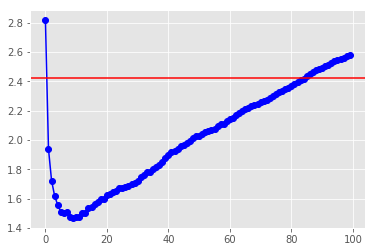

In [65]:
plt.plot(knn_mses,'-o', color='blue')
plt.axhline(y=lm_mse_d, color='r')
plt.show()

## Question 2 [50 Points] Linear Regression through Optimization

## 2A. [35 Points] Based on this description, write your own R function mylm_g(x, y, delta, epsilon, maxitr) to implement this optimization version of linear regression. The output of this function should be a vector of the estimated beta value.

### Answer: 

In [1]:
def gradient_descent(x, y, b, delta, epsilon, maxitr):
    iterations = 1
    cost_history = []
    m = len(y)

    while True:
        h = x.dot(b)
        loss = h - y

        gradient = x.T.dot(loss) / m

        b_new = b - delta * gradient

        cost = np.sum(abs(b_new - b))
        cost_history.append(cost)
        
        b = b_new
        
        if cost < epsilon:
            break
            
        if iterations == maxitr:
            break
        
        iterations +=1

    return b, cost_history

In [70]:
def mylm_g(x, y, delta, epsilon, maxitr):
    beta = np.zeros(x.shape[1])
    newB, _ = gradient_descent(x, y, beta, delta, epsilon, maxitr)
    return newB

## 2B. [15 Points] Test this function on the Boston Housing data from the mlbench package. Documentation is provided here if you need a description of the data. We will remove medv, town and tract from the data and use cmedv as the outcome. We will use a scaled and centered version of the data for estimation. Please also note that in this case, you do not need the intercept term. And you should compare your result to the lm() function on the same data. Experiment on different maxitr values to obtain a good solution. However your function should not run more than a few seconds.

### Answer: 

In [75]:
from sklearn.preprocessing import scale

In [76]:
x = pd.read_csv('./boston-data.csv')

In [77]:
x = x.drop([x.columns[0],'medv', 'town', 'tract'],axis=1)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [79]:
y = x.cmedv.to_numpy()

In [80]:
x = x.drop(['cmedv'],axis=1).to_numpy()

In [81]:
# Train params
delta = 0.1
epsilon = 1e-7
max_iterations = 5000

In [85]:
my_beta_2b = mylm_g(x,y, delta, epsilon, max_iterations)

In [86]:
reg = LinearRegression().fit(x, y)

In [87]:
lm_beta_2b = reg.coef_

In [91]:
beta_df = pd.DataFrame({'LinearRegression': lm_beta_2b, 'mylm_g': my_beta_2b})

In [92]:
beta_df

,LinearRegression,mylm_g
0,-0.032316,-0.032317
1,0.030245,0.030245
2,-0.097936,-0.097936
3,0.118273,0.118272
4,0.011390,0.011388
5,0.071312,0.071313
6,-0.199704,-0.199703
7,0.287233,0.287233
8,0.007565,0.007565
9,-0.321039,-0.321039
